In [1]:
import numpy as np
import pandas as pd
import warnings
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

df = pd.read_csv("NewData.csv")
data =df.values

#scaler = MinMaxScaler()
scaler = StandardScaler()
result_feature = scaler.fit_transform(data[:,:19])
result_label = data[:,19]
result = np.append(result_feature, result_label.reshape(len(result_label),1), axis = 1)
df_newdata = pd.DataFrame(result, columns= df.columns)


Y = df["Outcome"].values
X = df[['Gender', 'Age', 'Height', 'Weight', 'BMI', 'Hypertension',
       'SBP', 'DBP', 'PR', 'Drink', 'Smoke', 'FPG', 'AST', 'ALT', 'BUN', 'Scr',
       'TG', 'TC']].values
names = ['Gender', 'Age', 'Height', 'Weight', 'BMI', 'Hypertension',
       'SBP', 'DBP', 'PR', 'Drink', 'Smoke', 'FPG', 'AST', 'ALT', 'BUN', 'Scr',
       'TG', 'TC']


score = 'f1'

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

clfrf = RandomForestClassifier(n_estimators=35, max_depth= 5, max_features= 4)
clfSVC =  SVC(C= 20, kernel = 'linear', probability= True)
clfGBDT = GradientBoostingClassifier(n_estimators=45, max_depth= 4, max_features= 3)
clfXGBT = XGBClassifier(n_estimators=35, max_depth= 5, learning_rate= 0.01)

df_weights = pd.read_csv("Weight.csv")

print(df_weights[df_weights.columns[0]])
df_weights = df_weights.drop([df_weights.columns[0],df_weights.columns[-1]], axis= 1)



0       RF
1      SVM
2     GBDT
3      XGB
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
Name: Unnamed: 0, dtype: object


In [3]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, ShuffleSplit

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
max_score = 0
max_weights = []
for index, col in tqdm(df_weights.iteritems()):
    #print(col)
    clf_weights = col.values[:4]*10
    print(clf_weights)
    vclf = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='soft', weights= clf_weights)
    score = cross_val_score(vclf, X, Y, cv=ShuffleSplit(10, test_size = .1, train_size = .9), n_jobs = 6)
    print(score)
    print(sum(score)/len(score))

    if max_score<(sum(score)/len(score)):
        max_weights = clf_weights
        max_score = sum(score)/len(score)

print(max_score, max_weights)

    

0it [00:00, ?it/s]

[3. 3. 3. 1.]


1it [05:41, 341.10s/it]

[0.75396825 0.72222222 0.76190476 0.73015873 0.65079365 0.70634921
 0.76984127 0.70634921 0.83333333 0.79365079]
0.7428571428571428
[3. 3. 2. 2.]


2it [11:44, 354.51s/it]

[0.75396825 0.83333333 0.69047619 0.76190476 0.68253968 0.71428571
 0.69047619 0.76984127 0.80952381 0.75396825]
0.746031746031746
[3. 2. 3. 2.]


3it [16:51, 332.61s/it]

[0.71428571 0.72222222 0.70634921 0.78571429 0.73015873 0.73809524
 0.73015873 0.73809524 0.70634921 0.79365079]
0.7365079365079366
[3. 1. 3. 3.]


4it [21:45, 317.31s/it]

[0.69047619 0.71428571 0.76984127 0.74603175 0.76984127 0.69047619
 0.6984127  0.73015873 0.74603175 0.72222222]
0.7277777777777777
[4. 4. 1. 1.]


5it [26:46, 311.44s/it]

[0.78571429 0.73809524 0.70634921 0.73809524 0.76984127 0.76190476
 0.76190476 0.75396825 0.74603175 0.71428571]
0.7476190476190476
[4. 3. 2. 1.]


6it [32:04, 313.55s/it]

[0.73809524 0.80952381 0.70634921 0.68253968 0.76190476 0.69047619
 0.71428571 0.73809524 0.71428571 0.6984127 ]
0.7253968253968255
[4. 2. 3. 1.]


7it [37:08, 310.55s/it]

[0.72222222 0.76984127 0.68253968 0.68253968 0.75396825 0.70634921
 0.74603175 0.77777778 0.74603175 0.76984127]
0.7357142857142858
[4. 2. 2. 2.]


8it [41:58, 304.11s/it]

[0.65873016 0.73809524 0.81746032 0.74603175 0.73015873 0.70634921
 0.76190476 0.71428571 0.70634921 0.76190476]
0.7341269841269842
[4. 1. 4. 1.]


9it [46:35, 295.42s/it]

[0.69047619 0.75396825 0.78571429 0.8015873  0.70634921 0.81746032
 0.73809524 0.73809524 0.72222222 0.70634921]
0.746031746031746
[4. 1. 3. 2.]


10it [51:49, 301.35s/it]

[0.6984127  0.81746032 0.76190476 0.76190476 0.78571429 0.72222222
 0.76984127 0.80952381 0.72222222 0.76190476]
0.7611111111111111
[5. 3. 1. 1.]


11it [57:03, 305.29s/it]

[0.79365079 0.68253968 0.76984127 0.71428571 0.68253968 0.74603175
 0.74603175 0.74603175 0.75396825 0.66666667]
0.7301587301587302
[5. 2. 2. 1.]


12it [1:02:11, 305.85s/it]

[0.76984127 0.76984127 0.81746032 0.79365079 0.78571429 0.79365079
 0.71428571 0.77777778 0.8015873  0.81746032]
0.7841269841269841
[5. 1. 3. 1.]


13it [1:07:47, 315.13s/it]

[0.73809524 0.70634921 0.79365079 0.79365079 0.76984127 0.76190476
 0.76190476 0.76984127 0.75396825 0.81746032]
0.7666666666666666
[5. 1. 2. 2.]


14it [1:12:44, 309.61s/it]

[0.73015873 0.6984127  0.70634921 0.74603175 0.74603175 0.75396825
 0.75396825 0.73809524 0.74603175 0.76984127]
0.7388888888888889
[6. 2. 1. 1.]


15it [1:17:42, 305.99s/it]

[0.8015873  0.77777778 0.8015873  0.74603175 0.8015873  0.75396825
 0.73809524 0.76984127 0.76190476 0.74603175]
0.7698412698412699
[6. 1. 2. 1.]


16it [1:22:26, 299.47s/it]

[0.6984127  0.68253968 0.73809524 0.73015873 0.73015873 0.75396825
 0.73015873 0.76984127 0.75396825 0.77777778]
0.7365079365079366
[7. 1. 1. 1.]


17it [1:27:42, 309.54s/it]

[0.79365079 0.76190476 0.72222222 0.67460317 0.75396825 0.77777778
 0.77777778 0.76190476 0.6984127  0.81746032]
0.753968253968254
0.7841269841269841 [5. 2. 2. 1.]


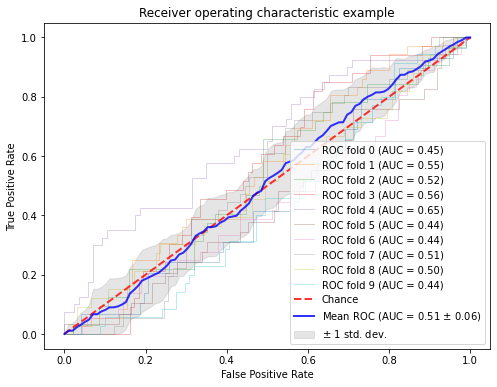

In [3]:
from numpy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#if len(Y)
n_classes = Y.shape
cv = ShuffleSplit(10, test_size = .1, train_size = .9)
classifier = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='soft', weights= [5, 2, 2, 1])
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
i = 0
for train, test in cv.split(X, Y):
    y_score = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # y_score.shape==(75, 3)
    #if len(y_score.shape)<= 1 :
    #    y_score = y_score[:, np.newaxis]
    # 为每个类别计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(Y[test], y_score[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [4]:
from numpy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#if len(Y)
n_classes = Y.shape
cv = ShuffleSplit(10, test_size = .1, train_size = .9)
classifier = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='soft', weights= [5, 2, 2, 1])
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
i = 0
for train, test in cv.split(X, Y):
    y_score = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # y_score.shape==(75, 3)
    #if len(y_score.shape)<= 1 :
    #    y_score = y_score[:, np.newaxis]
    # 为每个类别计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(Y[test], y_score[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

AttributeError: predict_proba is not available when voting='hard'

<Figure size 576x432 with 0 Axes>

In [ ]:
for samp in range(20):
    df_samp = df.sample(n=400)
    